In [10]:
## Constants ##

TESTSUITE = '1677432096341181278'
FIELDS = {
    'sender':  str,
    'sent':    int,   # [ns]
    'arrival': int,   # [ns]
    'valid':   bool,
    'headway': float, # [s]
    'safe':    bool,
}
FIELD_SEP = ','
ENTRY_SEP = ';'

In [11]:
## Setup Paths ## 

from pathlib import Path

PROJ_DIR = Path().absolute().parent
TESTSUITE_DIR = PROJ_DIR / 'log' / TESTSUITE

print(f'Chosen directory: {TESTSUITE_DIR.absolute()}')

Chosen directory: /home/kaarmu/Projects/wp3_tests/src/wp3_tests/log/1677432096341181278


In [12]:
## Import Test Cases ## 

import json
from dataclasses import dataclass

import numpy as np
import pandas as pd

@dataclass
class Conf:
    AGENTS: int      # [1]
    INIT_POS: float  # [m]
    TARG_VEL: float  # [m/s]
    TIME_STEP: float # [s]
    DATA_SIZE: float # [kB]
    DATA_FREQ: float # [Hz]
    COMP_TIME: float # [s]
    COMP_ORDR: float # [1]
        
    @property
    def compute_time(self):
        return (
            self.COMP_TIME
            * len(self.AGENTS)**self.COMP_ORDR
        )

cfs = {} # { test: configuration }
dfs = {} # { (test, vehicle): dataframe }
for path in TESTSUITE_DIR.iterdir():
    test = path.name
    for filepath in path.iterdir():
        with open(filepath) as f:
            if filepath.name == 'conf':
                cfs[test] = Conf(**json.load(f))
            else:
                vehicle = filepath.name
                dfs[test, vehicle] = pd.read_csv(f, 
                                                 names=FIELDS,
                                                 dtype=FIELDS,
                                                 lineterminator=ENTRY_SEP)

print(f'Collected {len(dfs)} number of testcases')

Collected 1822 number of testcases


## Latency vs Packet Size

**Background**: ???

**Description**: ???

**Expected Result**: ???

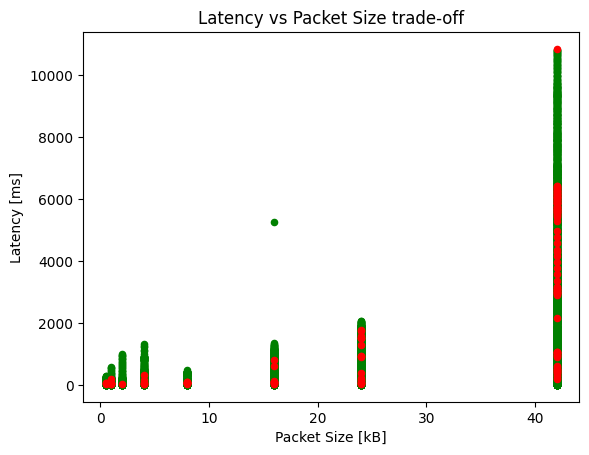

In [41]:
import matplotlib.pyplot as plt

# Device Under Test i.e. the vehicle(s) we want to examine
DUT = 'svea2', 'svea5'

fig = plt.figure()
ax = fig.gca() 

res = pd.DataFrame(columns=['Packet Size', 'Latency', 'Safe']).astype({'Safe': bool})
for test, vehicle in dfs:

    if isinstance(DUT, tuple) and vehicle not in DUT: continue
    elif isinstance(DUT, str) and vehicle != DUT: continue
    
    df = dfs[test, vehicle]
    
    new = pd.DataFrame({
        'Packet Size': cfs[test].DATA_SIZE,
        'Latency': (df['arrival'] - df['sent']) / 1e6, # [ms]
        'Safe': df['safe'].astype(bool),
    })
    
    res = pd.concat([res, new], ignore_index=True)

safe = res[res['Safe']]
unsafe = res[~res['Safe']]

safe.plot.scatter(x='Packet Size', y='Latency', c='green', ax=ax)
unsafe.plot.scatter(x='Packet Size', y='Latency', c='red', ax=ax)

ax.set_title('Latency vs Packet Size trade-off')
ax.set_xlabel('Packet Size [kB]')
ax.set_ylabel('Latency [ms]')

None

## Computational Complexity

**Background**:
???

**Description**: 
???

**Expected Result**: 
???

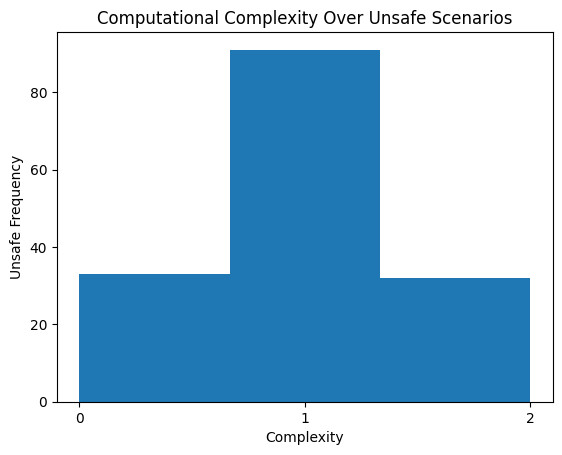

In [79]:
import matplotlib.pyplot as plt

# Device Under Test i.e. the vehicle(s) we want to examine
DUT = 'svea2', 'svea5'

fig = plt.figure()
ax = fig.gca() 

res = pd.DataFrame(columns=['complexity', 'safe']).astype({'safe': bool})
for test, vehicle in dfs:

    if isinstance(DUT, tuple) and vehicle not in DUT: continue
    elif isinstance(DUT, str) and vehicle != DUT: continue
    
    df = dfs[test, vehicle]
    
    new = pd.DataFrame({
        'complexity': cfs[test].COMP_ORDR,
        'safe': df['safe'].astype(bool),
    })
    
    res = pd.concat([res, new], ignore_index=True)

safe = res[res['safe']]
unsafe = res[~res['safe']]

unsafe['complexity'].plot.hist(bins=3, xticks=(0, 1, 2), ax=ax)

ax.set_title('Computational Complexity Over Unsafe Scenarios')
ax.set_xlabel('Complexity')
ax.set_ylabel('Unsafe Frequency')

None

## How far does the vehicle go?

**Background**:
When the vehicle becomes unsafe, the vehicle will finish the test.
Thus, if we look at the headway at the last time step of each test
case then we can determine how near the intersection a vehicle can
go before becoming unsafe.

**Description**:
This is a measure of ...
    
**Expected Result**:
That vehicles reach the intersection while being safe. 

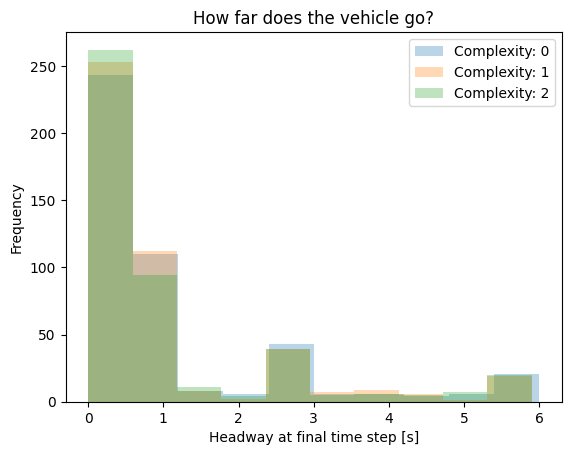

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Device Under Test i.e. the vehicle(s) we want to examine
DUT = 'svea2', 'svea5'

fig = plt.figure()
ax = fig.gca()

res = pd.DataFrame()
for test, vehicle in dfs:

    if isinstance(DUT, tuple) and vehicle not in DUT: continue
    elif isinstance(DUT, str) and vehicle != DUT: continue
    elif dfs[test, vehicle].empty: continue
    
    df = dfs[test, vehicle]    
    new = pd.DataFrame({
        'complexity': cfs[test].COMP_ORDR,
        'headway': df['headway'],
    })
    
    res = pd.concat([res, new.tail(1)], ignore_index=True)

for i in range(3):
    
    r = res[res['complexity'] == i]
    
    # safe = r[r['safe']]
    # unsafe = r[~r['safe']]
    
    r['headway'].plot.hist(alpha=0.3, label=f'Complexity: {i}', ax=ax)

ax.set_title('How far does the vehicle go?')
ax.set_xlabel('Headway at final time step [s]')
ax.legend()

None

## How far does the vehicle go?

**Background**:
???

**Description**:
Compare the actual compute time (i.e. including complexity) to the 
last headway time (i.e. a measure of distance to the intersection).

**Expected Result**:
Higher compute time should lead to higher number of unsafe scenarios.

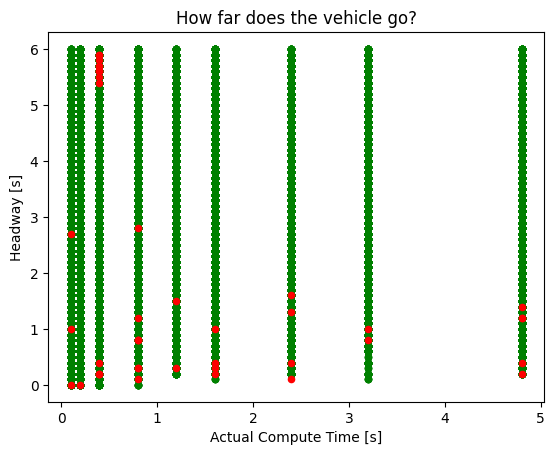

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Device Under Test i.e. the vehicle(s) we want to examine
DUT = 'svea5'

fig = plt.figure()
ax = fig.gca()

res = pd.DataFrame()
for test, vehicle in dfs:

    if isinstance(DUT, tuple) and vehicle not in DUT: continue
    elif isinstance(DUT, str) and vehicle != DUT: continue
    elif dfs[test, vehicle].empty: continue
    
    df = dfs[test, vehicle]    
    new = pd.DataFrame({
        'compute_time': cfs[test].compute_time,
        'headway': df['headway'],
        'safe': df['safe'].astype(bool),
    })
    
    res = pd.concat([res, new], ignore_index=True)

safe = res[res['safe']]
unsafe = res[~res['safe']]
    
safe.plot.scatter(x='compute_time', y='headway', c='green', ax=ax)
unsafe.plot.scatter(x='compute_time', y='headway', c='red', ax=ax)

ax.set_title('How far does the vehicle go?')
ax.set_xlabel('Actual Compute Time [s]')
ax.set_ylabel('Headway [s]')

None

## Number of Crashes

**Background**:
Even if we loose connection to the internet, it is 
not certain that we crash! Instead of only looking 
at unsafe (which really means "not connected") we 
can look if the vehicle is unsafe before/after the 
minimum braking distance. The braking distance is 
roughly equal to 

$$ d = \frac{v^2}{250f} $$

where $d$ is the braking distance in `[m]`, $v$ is 
the velocity in `[km/h]` and f is the friction 
number. The friction number is typically $f=0.8$ for
dry asphalt and $f=0.1$ for smooth ice. 

In these experiments we could cautiously set 
$f=0.6$ and get the following approximate table:

| Velocity `[m/s]` | Braking distance `[m]` |
|------------------|------------------------|
| 5                | 2.1                    |
| 10               | 8.6                    |
| 20               | 34.5                   |


**Description**:
???

**Expected Result**:
???

In [100]:
# first, second = res.iloc[:-1], res.iloc[1:]
# first["Headway"].to_numpy() < second["Headway"].to_numpy()

# bs = first["Headway"].to_numpy() >= second["Headway"].to_numpy()
# ns = ~(first["Safe"] & pd.Series(bs))

# first["Headway"]

dfs[test, vehicle].dtypes

print(np.float64('5.4'))

5.4
